INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 2862 images belonging to 6 classes.
Epoch 1/20
701/701 [==============================] - ETA: 0s - loss: 0.5855 - accuracy: 0.8055
Epoch 1: val_accuracy improved from -inf to 0.70750, saving model to best_model.h5
701/701 [==============================] - 210s 256ms/step - loss: 0.5855 - accuracy: 0.8055 - val_loss: 0.7950 - val_accuracy: 0.7075 - lr: 1.0000e-04
Epoch 2/20
701/701 [==============================] - ETA: 0s - loss: 0.3890 - accuracy: 0.8706
Epoch 2: val_accuracy improved from 0.70750 to 0.87107, saving model to best_model.h5
701/701 [==============================] - 175s 249ms/step - loss: 0.3890 - accuracy: 0.8706 - val_loss: 0.3567 - val_a

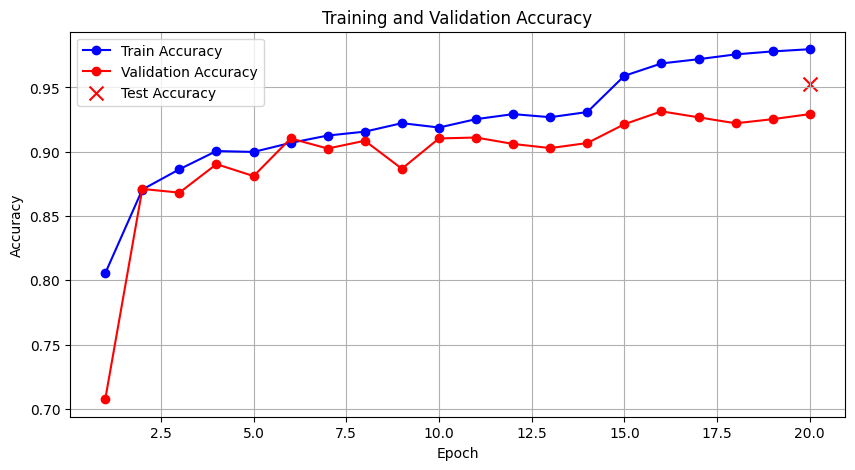

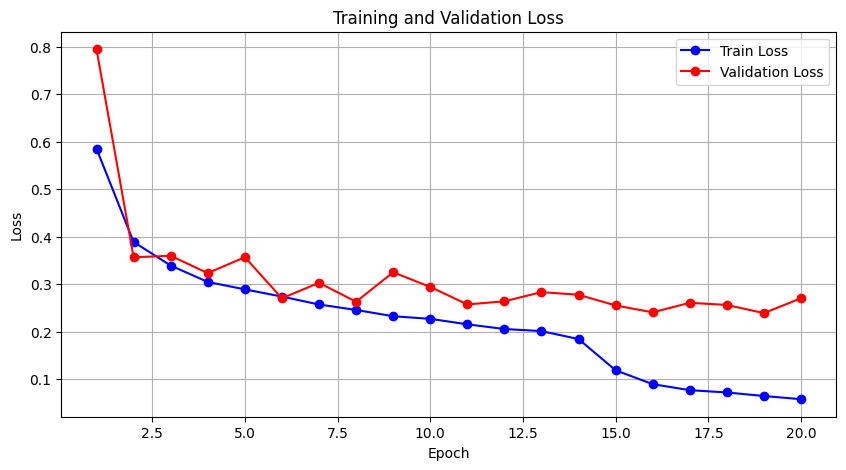

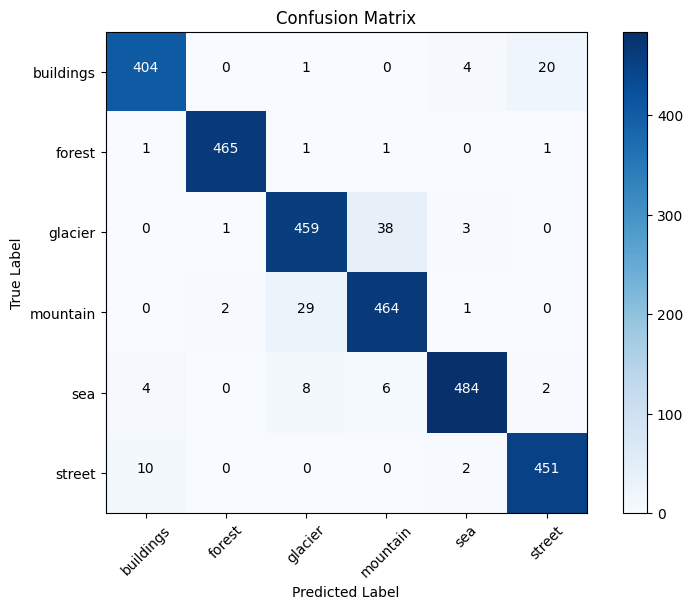

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools


# Modify warning filtering
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")

# Enable mixed precision training (GPU support)
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Data paths
train_data_dir = 'archive/seg_train/seg_train'
test_data_dir = 'archive/seg_test/seg_test'

# Define hyperparameters
image_size = (224, 224)
epochs = 20
batch_size = 16

# Define class order
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    channel_shift_range=0.1,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

# Build the model
base_model = tf.keras.applications.ResNet152(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3)
)

# Fine-tune ResNet layers
for layer in base_model.layers[-5:]:
    layer.trainable = True

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=[early_stopping, reduce_lr, checkpoint]
    )

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Test set evaluation
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print('accuracy：', accuracy)

# Plot training curves
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy', marker='o', color='blue')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', marker='o', color='red')
plt.scatter(len(train_acc), accuracy, marker='x', color='red', s=100, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', marker='o', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()